# Part III : Training

The training of a model is splitted in three steps : data loading / training and validating / Save and test

Import libraries

In [ ]:
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.vision.data import *
from osgeo import gdal
from utils import utils
import gc

In [ ]:
import torch
print(torch.cuda.get_device_name(0))

# -Loss function and metrics-

Building the loss function, based on :

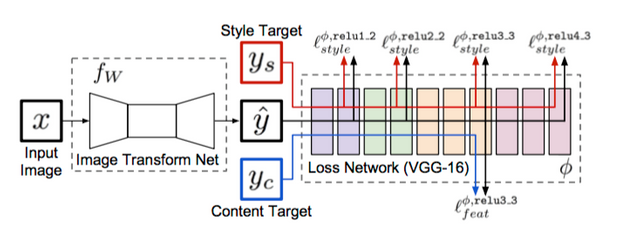

"Perceptual Losses for Real-Time Style Transfer and Super-Resolution" Justin Johnson, Alexandre Alahi, Li Fei-Fei
and 
Fastai Lesson 7: Deep Learning 2019

The loss function build is a feature loss function to retrieve a similar structure than the target while reconstructing the output. The function is based on a VGG model.

In [ ]:
from utils.loss import VGG, gram_matrix, FeatureLoss
VGG1 = VGG(1) # import a vgg model
vgg_m = VGG1.cuda().eval()
requires_grad(vgg_m)
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks] # layers numbers before the max pooling layer

criterion = FeatureLoss(vgg_m, blocks[2:5], [5,12,2])
#creating the loss function that will be set up when loading the opt state of the model

Metrics to estimate the result : PSNR (Peak Signal to Noise Ratio) / SSIM (Structural Similarity Index Measure)

In [ ]:
from utils.metrics import PSNR, ssim
psnr = PSNR(1) # set up max of your dataset, usually set to 1

# -Data loading parameters-

Dataloader functions

In [ ]:
from utils.dataloader import createDLS, PProcess
def getLab(path): # function to retrieve the target based on the input (will differ based on how you created the dataset)
    path = str(path).replace('CAMS', 'S5P') # in our case the dataset was set up to make tiles totally similar
    return Path(path) # the only element different is on the sensor name
# for instance : S5P_yyyymmddTH_ntile.tif --> CAMS_yyyymmddTH_ntile.tif 

# this function differ based on the way you organized your dataset

https://docs.fast.ai/data.block.html

# -Initialization-

In [ ]:
Pscale2 = Path('') # x2 path for the location of the datasets with the different scales
Pscale4 = Path('') # x4
Pscale8 = Path('') # x8

In [ ]:
size = # size of the target to reach
net = xresnet34 #https://docs.fast.ai/vision.models.xresnet.html
arch = 'SRResnet34' # define the resnet model you would like to use

nc = # number of channel -> 1 (in the use of NO2 measurement)
bs =  # batch size : number of training examples utilized in one iteration
epochs =  # number of loop for training

# transforms for data augmentation
tfms = [] # all infos of data augmentation here : https://docs.fast.ai/vision.augment.html

In [ ]:
Pinput2 = Pscale2/'INPUT' # Identify the directory where to find the input tiles
Pinput4 = Pscale4/'INPUT'
Pinput8 = Pscale8/'INPUT'

In [ ]:
DS2 = createDLS(Pinput2, bs, nc, getLab, tfms, False, 1, size) # create the dataset with your dataloader
DS4 = createDLS(Pinput4, bs, nc, getLab, tfms, False, 1, size)
DS8 = createDLS(Pinput8, bs, nc, getLab, tfms, False, 1, size) # function for dataloader in utils/dataloader.py

# the dataloader function used triggered the upsampling

In [ ]:
print("S5P x2 CAMS, Training : ", len(DS2.train.dataset),", Validation :", len(DS2.valid.dataset))
print("S5P x4 CAMS, Training : ", len(DS4.train.dataset),", Validation :", len(DS4.valid.dataset))
print("S5P x8 CAMS, Training : ", len(DS8.train.dataset),", Validation :", len(DS8.valid.dataset))

In [ ]:
DS2.show_batch()

In [ ]:
DS4.show_batch()

In [ ]:
DS8.show_batch()

# -Baseline-

Identify a baseline metric value with the dataset we have, to define if an improvement is made while training. Obviously the baseline is just a statement of how the data is right now, but it is not especially meaningfull on how much we can improve.

In [ ]:
m1l = []
m2l = []


for i in range(len(DS2.valid.dataset)):
    INP = DS2.valid.dataset[i][0]
    TARG = DS2.valid.dataset[i][1]
    p = psnr.forward(INP, TARG)
    s = ssim(INP.unsqueeze(0), TARG.unsqueeze(0))
    m1l.append(float(p))
    m2l.append(float(s))
print('Scaling x 2')
print('Average PSNR baseline value of validation dataset : {}'.format(np.mean(m1l)))
print('Average SSIM baseline value of validation dataset : {}'.format(np.mean(m2l)))

In [ ]:
m1l = []
m2l = []


for i in range(len(DS4.valid.dataset)):
    INP = DS4.valid.dataset[i][0]
    TARG = DS4.valid.dataset[i][1]
    p = psnr.forward(INP, TARG)
    s = ssim(INP.unsqueeze(0), TARG.unsqueeze(0))
    m1l.append(float(p))
    m2l.append(float(s))   
print('Scaling x 4')   
print('Average PSNR baseline value of validation dataset : {}'.format(np.mean(m1l)))
print('Average SSIM baseline value of validation dataset : {}'.format(np.mean(m2l)))

In [ ]:
m1l = []
m2l = []


for i in range(len(DS8.valid.dataset)):
    INP = DS8.valid.dataset[i][0]
    TARG = DS8.valid.dataset[i][1]
    p = psnr.forward(INP, TARG)
    s = ssim(INP.unsqueeze(0), TARG.unsqueeze(0))
    m1l.append(float(p))
    m2l.append(float(s))
print('Scaling x 8')    
print('Average PSNR baseline value of validation dataset : {}'.format(np.mean(m1l)))
print('Average SSIM baseline value of validation dataset : {}'.format(np.mean(m2l)))

# -Training-

Training loop

In [ ]:
def train(learn, epochs, lr, monitor, model_fname = 'test') :
    """
    learn : learner created for the training
    epochs : number of loop the model will do
    lr : learning rate
    monitor : which element to focus on to identify the convergence of the model
    model_fname : model name to save
    """
    learn.cuda() # move to the gpu
    learn.fit_one_cycle( # fit for training
                       epochs, # maximum of epochs to train
                       lr_max = lr, # learning rate
                       cbs=SaveModelCallback(monitor=monitor, # callback to stop if the model converged before the maximum of epoch set
                                                 fname = model_fname) 
                        )
    learn.recorder.plot_loss() # show the loss evolution
    learn.show_results() # show some results
    return learn # return the learner at new stage of training

# Scale x2

In [ ]:
DS2.cuda()
learn = unet_learner(DS2, # set up the learner with the created dataset
                net, # integrate a pre trained model (list here : https://docs.fast.ai/vision.models.xresnet.html)
                pretrained=True, # pretrain
                normalize=False, # no need for normalization as it is made in the pre processing
                wd=1e-3, # similar to learning rate
                metrics=[psnr.forward, ssim], # metrics to compute while training
                loss_func=criterion, # loss function
                n_in=nc, # number of channel that go in
                n_out=nc # number of channel expected in the output
                ) # metrics to compute while training and verify efficiency
learn.cuda()
gc.collect() # collect and free a part of memory

In [ ]:
lrFIND = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(lrFIND)

In [ ]:
lr = lrFIND.valley # learning rate, step of training for the modelization
learn.fine_tune(1, base_lr=lr) # making a first loops to initiliaze the model

In [ ]:
learn.unfreeze() # unfreeze to work on the entire model

In [ ]:
lrFIND = learn.lr_find(start_lr=1e-7, end_lr=1e-3, suggest_funcs=(minimum, steep, valley, slide))
print(lrFIND)

The model name will be based on the name of the dataset / the architecture / the batch size and the number of epochs for training

In [ ]:
pathM = '{}_{}_B{}_e{}'.format(str(Pscale2), arch, bs, epochs) #model name to save

In [ ]:
lr = lrFIND.valley
learn = train(learn, epochs = epochs, lr = lr, monitor='ssim', model_fname = pathM) # training the model for a certain amount of epochs

In [ ]:
learn.freeze()

Saving the model for transfer learning but also for inference

In [ ]:
learn.save(str(pathM))
pkl = 'models/' + str(pathM) + '.pkl'
learn.export(fname = pkl)

# Scale x4

In [ ]:
DS4.cuda()
learn = unet_learner(DS4, # set up the learner with the created dataset
                net, # integrate a pre trained model (list here : https://docs.fast.ai/vision.models.xresnet.html)
                pretrained=True, # pretrain
                normalize=False, # no need for normalization as it is made in the pre processing
                wd=1e-3, # similar to learning rate
                metrics=[psnr.forward, ssim], # metrics to compute while training
                loss_func=criterion, # loss function
                n_in=nc, # number of channel that go in
                n_out=nc # number of channel expected in the output
                ) # metrics to compute while training and verify efficiency
learn.cuda()
gc.collect() # collect and free a part of memory

In [ ]:
learn.load(pathM)

In [ ]:
lrFIND = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(lrFIND)

In [ ]:
lr = lrFIND.valley # learning rate, step of training for the modelization
learn.fine_tune(1, base_lr=lr) # making a first loops to initiliaze the model

In [ ]:
learn.unfreeze() # unfreeze to work on the entire model

In [ ]:
lrFIND = learn.lr_find(start_lr=1e-7, end_lr=1e-3, suggest_funcs=(minimum, steep, valley, slide))
print(lrFIND)

In [ ]:
pathM = '{}_{}_B{}_e{}'.format(str(Pscale4), arch, bs, epochs) #model name to save

In [ ]:
lr = lrFIND.valley
learn = train(learn, epochs = epochs, lr = lr, monitor='ssim', model_fname = pathM) # training the model for a certain amount of epochs

In [ ]:
learn.freeze()

In [ ]:
learn.save(str(pathM))
pkl = 'models/' + str(pathM) + '.pkl'
learn.export(fname = pkl)


# Scale x8

In [ ]:
DS8.cuda()
learn = unet_learner(DS8, # set up the learner with the created dataset
                net, # integrate a pre trained model (list here : https://docs.fast.ai/vision.models.xresnet.html)
                pretrained=True, # pretrain
                normalize=False, # no need for normalization as it is made in the pre processing
                wd=1e-3, # similar to learning rate
                metrics=[psnr.forward, ssim], # metrics to compute while training
                loss_func=criterion, # loss function
                n_in=nc, # number of channel that go in
                n_out=nc # number of channel expected in the output
                ) # metrics to compute while training and verify efficiency
learn.cuda()
gc.collect() # collect and free a part of memory

In [ ]:
learn.load(pathM)

In [ ]:
lrFIND = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(lrFIND)

In [ ]:
lr = lrFIND.valley # learning rate, step of training for the modelization
learn.fine_tune(1, base_lr=lr) # making a first loops to initiliaze the model

In [ ]:
learn.unfreeze() # unfreeze to work on the entire model

In [ ]:
lrFIND = learn.lr_find(start_lr=1e-7, end_lr=1e-3, suggest_funcs=(minimum, steep, valley, slide))
print(lrFIND)

In [ ]:
pathM = '{}_{}_B{}_e{}'.format(str(Pscale8), arch, bs, epochs) #model name to save

In [ ]:
lr = lrFIND.valley
learn = train(learn, epochs = epochs, lr = lr, monitor='ssim', model_fname = pathM) # training the model for a certain amount of epochs

In [ ]:
learn.freeze()

In [ ]:
pkl = 'models/' + str(pathM) + '.pkl'
learn.export(fname = pkl) # export the model like /path/to/model.pkl, export the content and optimizer state for inference

In [ ]:
print(pkl)

Your model is now trained and saved, you can move to a test performance to identify the efficiency of the model